# Mesh Generator for 2D Meshes from SRTM data

[Data source](http://viewfinderpanoramas.org/dem3.html)

[File format description](https://librenepal.com/article/reading-srtm-data-with-python/)

[Utilized reader](https://github.com/adamcharnock/python-srtm)

In [1]:

!python3 -m pip install --upgrade pip
!python3 -m pip install -r requirements.txt

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


## User input
  - point A
  - point B
  - resolution

In [2]:
# Letterspitze
lat_min = 46.64261
lon_min = 12.79465

# Goiselemandl
lat_max = 46.88674
lon_max = 12.77728
res = 1000

## Get SRTM Data

In [3]:
#from math import floor, ceil
#from numpy import arange
#latitude_data_sets = arange(floor(lat_min), floor(lat_max)+1)
#longitude_data_sets = arange(floor(lon_min), floor(lon_max)+1)
#
#import requests
#import os
#import zipfile
#try:
#    os.mkdir('./downloads')
#except FileExistsError:
#    pass
#
#for lat in latitude_data_sets:
#    for lon in longitude_data_sets:
#
#        srtm_patch_name = "N%02dE%03d" %(lat,lon)
#        data_set_name = "http://viewfinderpanoramas.org/dem1/%s.zip" %srtm_patch_name
#        print("Downloading %s" %data_set_name)
#        data = requests.get(data_set_name)
#        with open("./downloads/%s.zip" %srtm_patch_name,'wb') as f:
#            f.write(data.content)
#            f.close()
#
#        file_to_extract = "%s.hgt" %srtm_patch_name
#        try:
#            with zipfile.ZipFile("./downloads/%s.zip" %srtm_patch_name) as z:
#                with open(file_to_extract, 'wb') as f:
#                    f.write(z.read(file_to_extract))
#                    print("Extracted", file_to_extract)
#        except:
#            print("Invalid file")

## Read SRTM data

In [4]:
from numpy import arange
os.environ['SRTM1_DIR'] = "./"

from srtm import Srtm1HeightMapCollection
srtm1_data = Srtm1HeightMapCollection()
h = [srtm1_data.get_altitude(latitude=lat, longitude=lon) for (lat, lon) in zip(
    arange(lat_min, lat_max, (lat_max-lat_min)/res), 
    arange(lon_min, lon_max, (lon_max-lon_min)/res))]

from numpy import sqrt
r = [sqrt((lat-lat_min)**2 + (lon-lon_min)**2) for (lat, lon) in zip(
    arange(lat_min, lat_max, (lat_max-lat_min)/res), 
    arange(lon_min, lon_max, (lon_max-lon_min)/res))]

## Convert to m
$1^{\circ} \approx 60\text{NM} = 60*1.852\text{km}$

In [5]:
from numpy import array
x = 1852.0*60*array(r)

## Plot

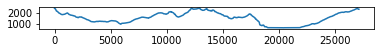

In [6]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.set_aspect('equal')
plt.plot(x, h)
plt.rcParams["figure.figsize"] = (40,10)

## Export as boundary mesh to be used in 2D Mesh generator etc.

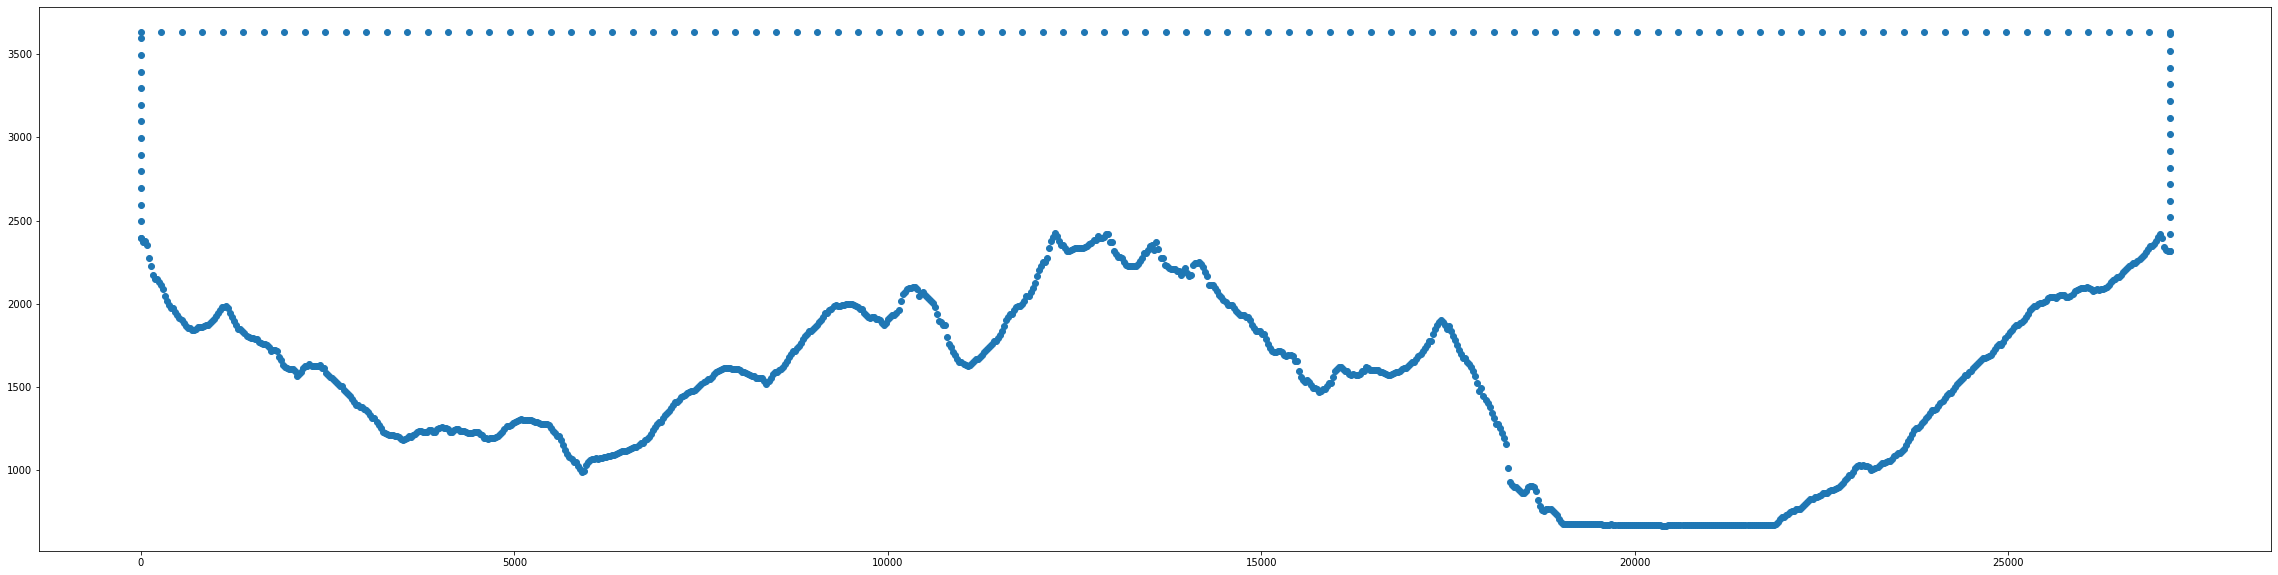

In [7]:
import meshio
from numpy import vstack, transpose, append, flip, amax, linspace, save

surface = transpose(vstack((x,h)))
xmax = x[-1]
xmin = x[0]
hmax = 1.5*amax(h)
right = [[xmax, h] for h in arange(h[-1], hmax, 100)]
left = flip([[xmin, h] for h in arange(h[0], hmax, 100)], axis=0)
top = flip([[x, hmax] for x in linspace(xmin, xmax, int(res/10))], axis=0)
boundary_points = vstack((surface, right, top, left))
line_ien = [[i,i+1] for i in range(len(boundary_points))]
cells = [("line", line_ien)]
mesh = meshio.Mesh(boundary_points, cells)
mesh.write("profile.vtk")
plt.scatter(boundary_points[:,0], boundary_points[:,1])
save('point.npy', boundary_points)

## Save boundaries for later meshing

In [8]:
save('surface.npy', surface)
save('top.npy', top)
save('left.npy', left)
save('right', right)